In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.24G/3.24G [02:47<00:00, 22.4MB/s]
100% 3.24G/3.24G [02:47<00:00, 20.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
'''Data Handling & Linear Algebra'''
import numpy as np
import pandas as pd
import os

'''Visualisation'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Manipulating Data and Model Building'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

'''Implementation of Transfer Learning'''
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19, ResNet50, ResNet101, ResNet152, ResNet50V2, InceptionV3, Xception, DenseNet121, NASNetMobile, EfficientNetB0

'''Image generation and preprocessing'''
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
'''Result and Performance Analysis'''
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

'''Ignoring Warnings'''
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DIR = '/content/Fish_Dataset/Fish_Dataset' #Creating a master directory
classes = [i for i in os.listdir(DIR) if '.' not in i]                     #Creating classes out of the required folders
classes

['Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Gilt-Head Bream',
 'Black Sea Sprat',
 'Striped Red Mullet',
 'Shrimp',
 'Trout',
 'Sea Bass']

In [ ]:
'''Since the GT images are of no use to us for the analysis, we will be separating them out of our directory'''

# Create a dataframe with a column which consists of all the filepaths (without GT) and its respective label as the other column

label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dirname.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dirname)[-1])         # Append the directory name to label
                path.append(os.path.join(dirname,filename))     # Append all the png files to path of that directory

# Ready to create the df
df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [ ]:
df.head()

path            label
0  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel
1  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel
2  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel
3  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel
4  /content/Fish_Dataset/Fish_Dataset/Hourse Mack...  Hourse Mackerel

In [ ]:
df.path[0]

'/content/Fish_Dataset/Fish_Dataset/Hourse Mackerel/Hourse Mackerel/00688.png'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [ ]:
df['label'].value_counts()

label
Hourse Mackerel       1000
Red Mullet            1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Shrimp                1000
Trout                 1000
Sea Bass              1000
Name: count, dtype: int64

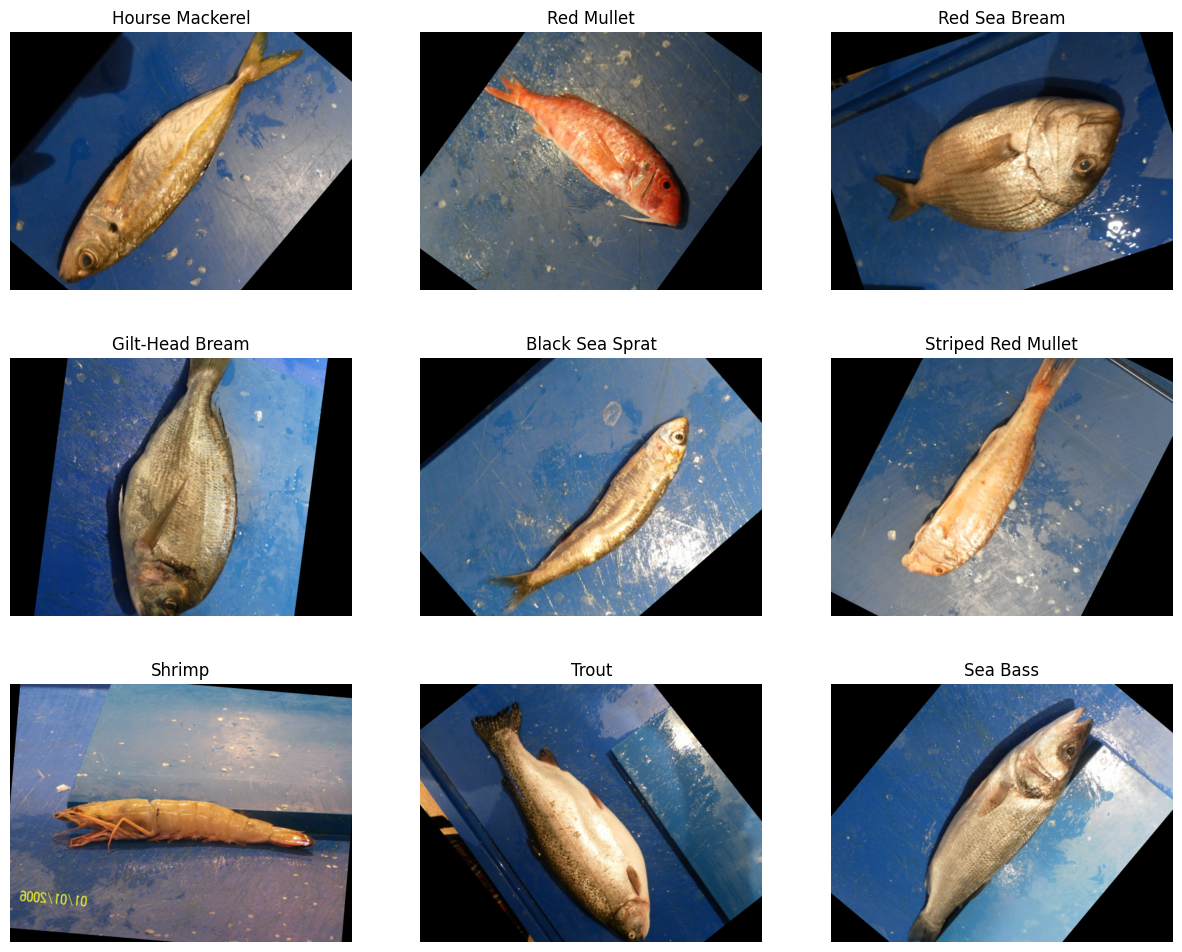

In [ ]:
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

Train-Test Data split

In [ ]:
#Creating the test train split with shuffle
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

Image Generation and Preprocessing

In [ ]:
#Using Keras Image Data Generator to preprocess our images with the model we wish to use
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='training')
val_images = train_generator.flow_from_dataframe(dataframe=train_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, seed=42, subset='validation' )
test_images = test_generator.flow_from_dataframe(dataframe=test_df, x_col='path', y_col='label', target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False )


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [ ]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

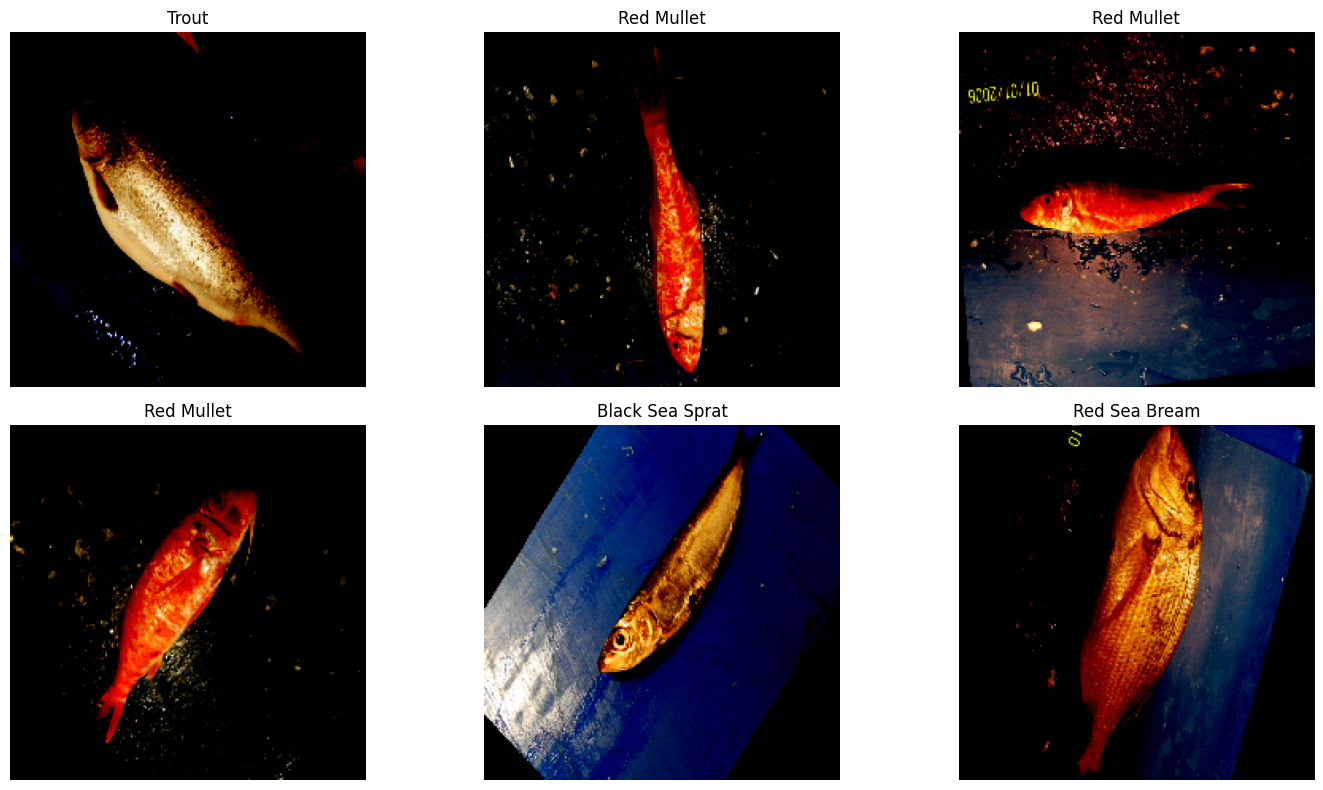

In [ ]:
# Plotting images after pre-processing
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
ax = ax.flatten()

class_indices = test_images.class_indices
class_labels = {v: k for k, v in class_indices.items()}

j = 0
for _ in range(6):
    img, label = test_images.next()
    ax[j].imshow(img[0])
    label_index = np.argmax(label[0])  # Convert one-hot encoding to label index
    label_name = class_labels[label_index]  # Get class name from index
    ax[j].set_title(label_name)
    ax[j].axis('off')
    j += 1

plt.tight_layout()
plt.show()

In [ ]:
# Importing our pretrained model:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classifier_activation="softmax",
)

9406464/9406464 [==============================] - 2s 0us/step


57/57 [==============================] - 19s 333ms/step


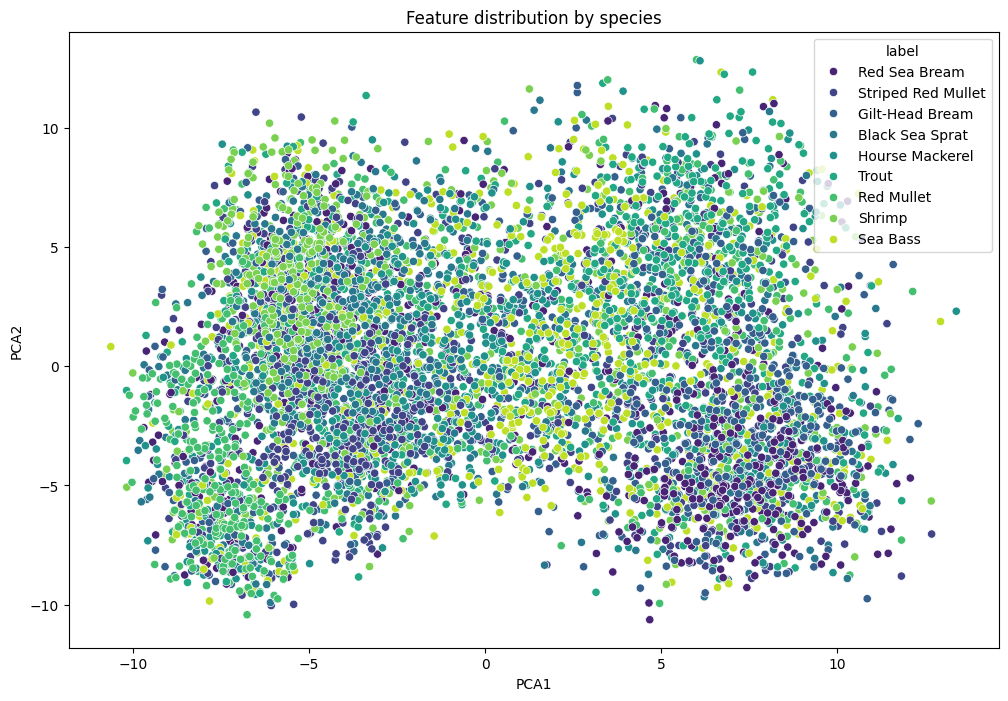

In [ ]:
from sklearn.decomposition import PCA

# Load the pretrained model without the top layer
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')

# Function to extract features using the pretrained model
def extract_features(generator, model):
    features = model.predict(generator)
    labels = generator.classes
    return features, labels

# Extract features for training and test data
train_features, train_labels = extract_features(train_images, pretrained_model)
test_features, test_labels = extract_features(test_images, pretrained_model)

# Convert labels to their respective class names
train_labels = np.array([class_labels[label] for label in train_labels])
test_labels = np.array([class_labels[label] for label in test_labels])

# Combine features and labels for analysis
features = np.concatenate([train_features, test_features])
labels = np.concatenate([train_labels, test_labels])

# Reduce dimensions for visualization
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Create a DataFrame for easy plotting
df_features = pd.DataFrame(features_2d, columns=['PCA1', 'PCA2'])
df_features['label'] = labels

# Plot the features
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_features, x='PCA1', y='PCA2', hue='label', palette='viridis')
plt.title('Feature distribution by species')
plt.show()

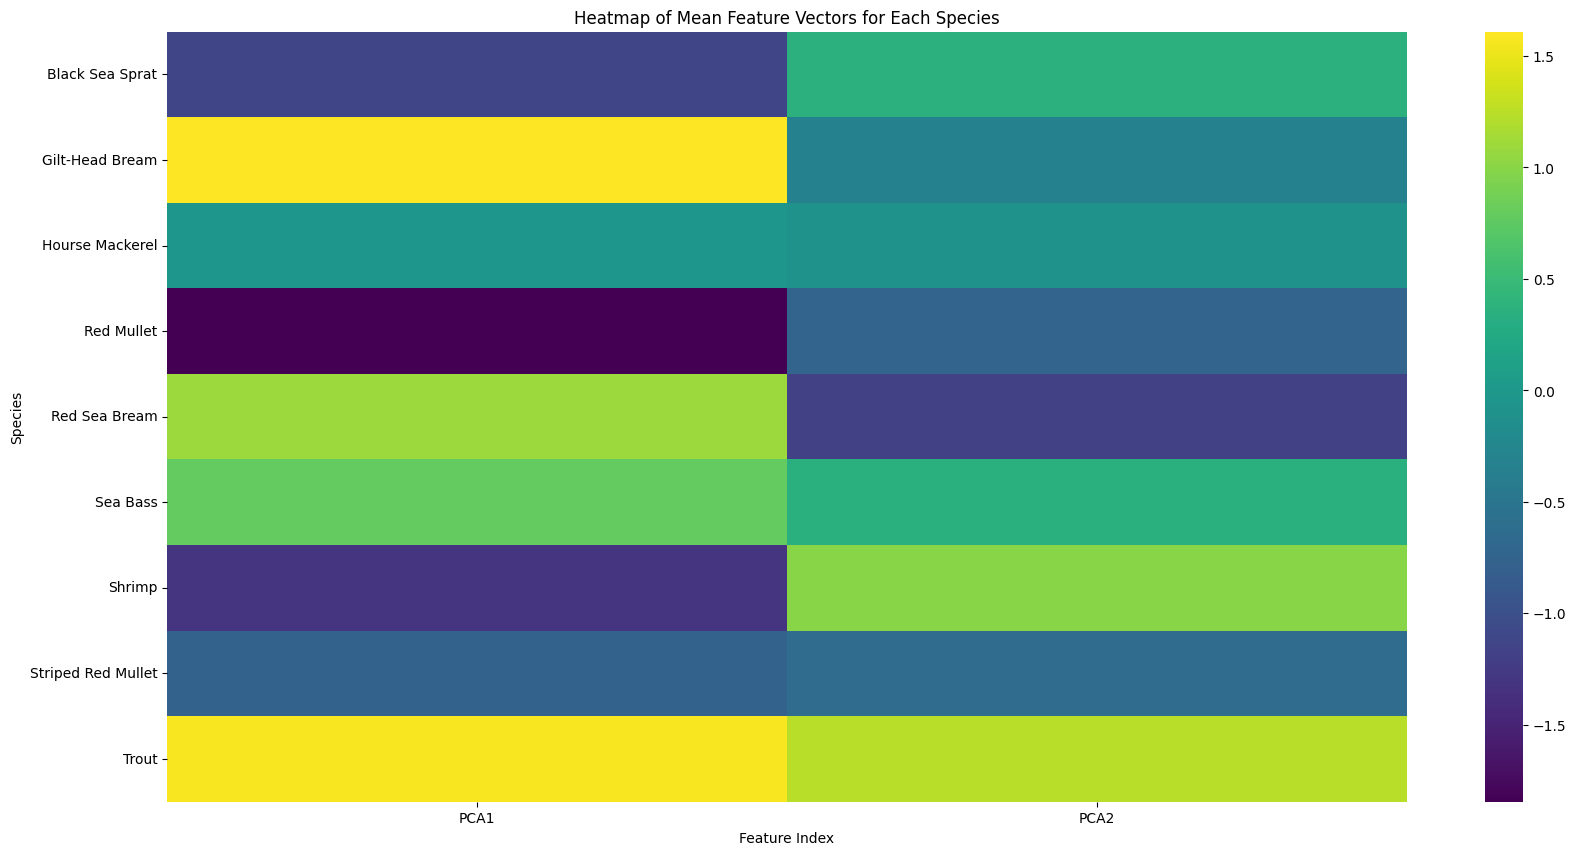

In [ ]:
# Calculate the mean feature vector for each species
mean_features = df_features.groupby('label').mean()

# Plot heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(mean_features, cmap='viridis')
plt.title('Heatmap of Mean Feature Vectors for Each Species')
plt.xlabel('Feature Index')
plt.ylabel('Species')
plt.show()

In [ ]:
# Creating our model inputs
inputs = pretrained_model.input

# Adding dense layers on top of the pretrained model
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(9, activation='softmax')(x)  # Assuming there are 9 classes

# Creating the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Model summary
model.summary()

# Compiling the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 12.36928
Test Accuracy: 27.22%


In [ ]:
pred = model.predict(test_images)
pred=np.argmax(pred,axis=1)

57/57 [==============================] - 20s 331ms/step


In [ ]:
pred_df=test_df.copy()
labels={}
for l,v in test_images.class_indices.items():
    labels.update({v:l})
pred_df['pred']=pred
pred_df['pred']=pred_df['pred'].apply(lambda x: labels[x])

In [ ]:
# Incorrect prediction
pred_df[pred_df['label']!=pred_df['pred']]

path               label  \
7940  /content/Fish_Dataset/Fish_Dataset/Trout/Trout...               Trout   
4081  /content/Fish_Dataset/Fish_Dataset/Black Sea S...     Black Sea Sprat   
5936  /content/Fish_Dataset/Fish_Dataset/Striped Red...  Striped Red Mullet   
3706  /content/Fish_Dataset/Fish_Dataset/Gilt-Head B...     Gilt-Head Bream   
4071  /content/Fish_Dataset/Fish_Dataset/Black Sea S...     Black Sea Sprat   
...                                                 ...                 ...   
7897  /content/Fish_Dataset/Fish_Dataset/Trout/Trout...               Trout   
3063  /content/Fish_Dataset/Fish_Dataset/Gilt-Head B...     Gilt-Head Bream   
6925  /content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...              Shrimp   
6521  /content/Fish_Dataset/Fish_Dataset/Shrimp/Shri...              Shrimp   
3002  /content/Fish_Dataset/Fish_Dataset/Gilt-Head B...     Gilt-Head Bream   

            pred  
7940    Sea Bass  
4081    Sea Bass  
5936  Red Mullet  
3706    Sea Bass  
4071    Sea Bass  
...          ...  
7897  Red Mullet  
3063    Sea Bass  
6925    Sea Bass  
6521    Sea Bass  
3002    Sea Bass  

[1310 rows x 3 columns]

In [ ]:
pred_df.path[7940]

'/content/Fish_Dataset/Fish_Dataset/Trout/Trout/00861.png'

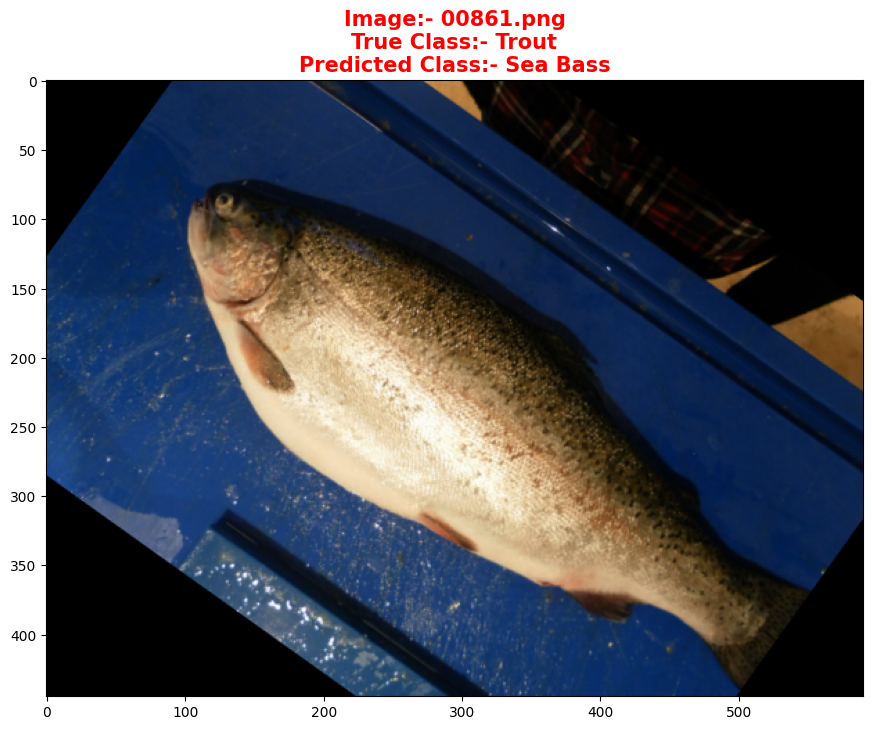

In [ ]:
#True label of incorrect prediction
plt.figure(figsize=(15,8))
plt.imshow(plt.imread(pred_df.path[7940]))
title1 = pred_df.path[7940].split('/')[-2]
title2 = pred_df.path[7940].split('/')[-1]
title3 = pred_df.pred[7940]
plt.title(f'Image:- {title2}\nTrue Class:- {title1}\nPredicted Class:- {title3}', color = 'r', weight = 'bold', fontsize = 15)
plt.show()

In [ ]:
# Calculate the accuracy score
accuracy = accuracy_score(pred_df['label'], pred_df['pred'])
print(f"Accuracy Score: {accuracy}")

Accuracy Score: 0.2722222222222222


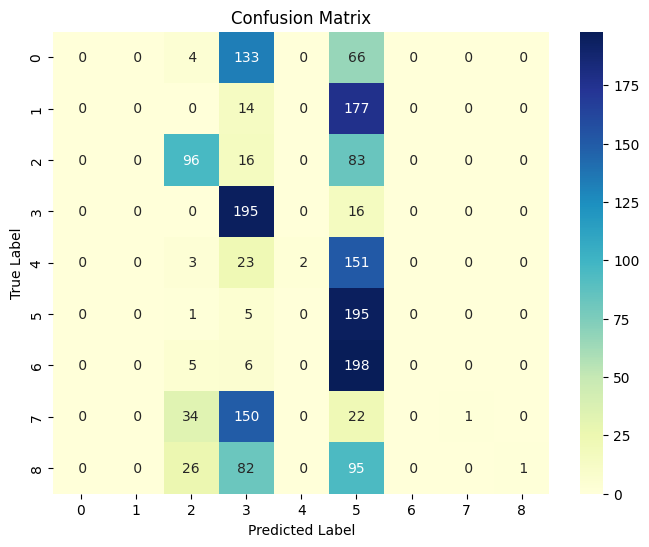

In [ ]:
# Create a confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(pred_df['label'], pred_df['pred']), annot=True, fmt='2d', cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(pred_df['label'], pred_df['pred'])
print(report)

                    precision    recall  f1-score   support

   Black Sea Sprat       0.00      0.00      0.00       203
   Gilt-Head Bream       0.00      0.00      0.00       191
   Hourse Mackerel       0.57      0.49      0.53       195
        Red Mullet       0.31      0.92      0.47       211
     Red Sea Bream       1.00      0.01      0.02       179
          Sea Bass       0.19      0.97      0.32       201
            Shrimp       0.00      0.00      0.00       209
Striped Red Mullet       1.00      0.00      0.01       207
             Trout       1.00      0.00      0.01       204

          accuracy                           0.27      1800
         macro avg       0.45      0.27      0.15      1800
      weighted avg       0.45      0.27      0.15      1800



1/1 [==============================] - 0s 28ms/step


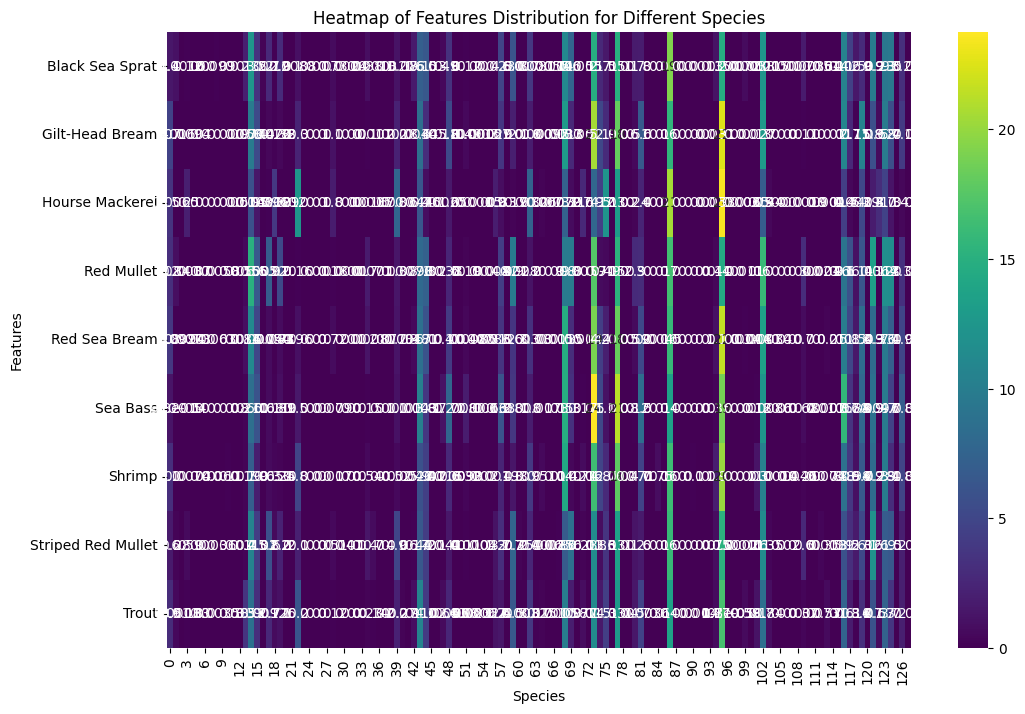

In [ ]:
# Define a function to get the intermediate layer model
def get_intermediate_layer_model(model, layer_name):
    return tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Initialize the intermediate layer model
intermediate_layer_model = get_intermediate_layer_model(model, 'dense')

# Prepare dictionaries to collect features
species_feature_map = {label: [] for label in train_images.class_indices.keys()}

# Iterate over the train_images batches
for i in range(len(train_images)):
    img_batch, label_batch = train_images[i]
    intermediate_output_batch = intermediate_layer_model.predict(img_batch)
    labels = np.argmax(label_batch, axis=1)
    for j in range(len(labels)):
        label = list(train_images.class_indices.keys())[labels[j]]
        species_feature_map[label].append(intermediate_output_batch[j])

# Convert the list of features to numpy arrays
for label in species_feature_map.keys():
    species_feature_map[label] = np.array(species_feature_map[label])

# Compute mean feature values for each species
mean_species_features = {label: np.mean(features, axis=0) for label, features in species_feature_map.items()}

# Convert to DataFrame for heatmap
mean_species_features_df = pd.DataFrame(mean_species_features)

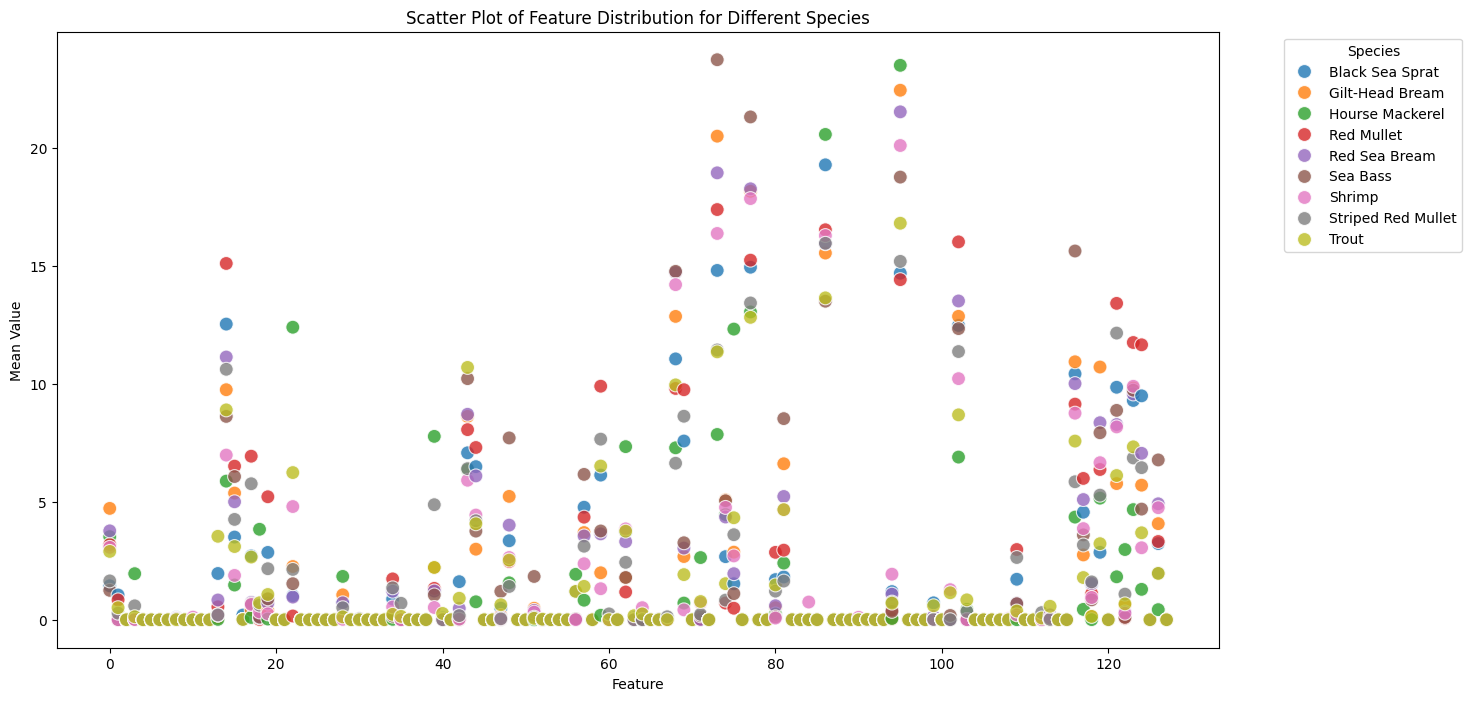

In [ ]:
# Compute the mean features for each species
# Here, we use the previously calculated mean_species_features dictionary
mean_species_features = {label: np.mean(features, axis=0) for label, features in species_feature_map.items()}

# Convert the dictionary to a DataFrame
mean_species_features_df = pd.DataFrame(mean_species_features)

# Transpose the DataFrame to have species as columns and features as rows
mean_species_features_df = mean_species_features_df.T

# Reset index to use species names as a column
mean_species_features_df.reset_index(inplace=True)
mean_species_features_df.rename(columns={'index': 'Species'}, inplace=True)

# Melt the DataFrame for easier plotting with seaborn
melted_df = mean_species_features_df.melt(id_vars='Species', var_name='Feature', value_name='Mean Value')

# Plotting the scatter plot
plt.figure(figsize=(15, 8))
sns.scatterplot(data=melted_df, x='Feature', y='Mean Value', hue='Species', palette='tab10', s=100, alpha=0.8)
plt.title('Scatter Plot of Feature Distribution for Different Species')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

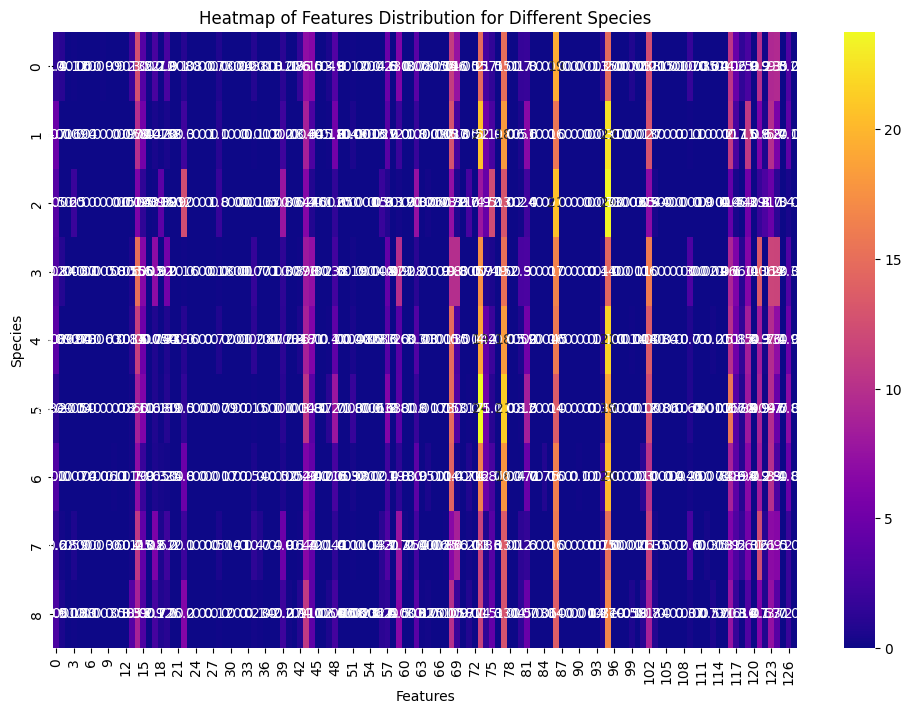

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming mean_species_features_df is the DataFrame with mean features and species as columns
# Remove the 'Species' column before plotting the heatmap
mean_species_features_df_no_species = mean_species_features_df.drop(columns='Species')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(mean_species_features_df_no_species, annot=True, cmap='plasma')
plt.title('Heatmap of Features Distribution for Different Species')
plt.xlabel('Features')  # Change 'Species' to 'Features' for x-axis label
plt.ylabel('Species')   # Add y-axis label for species
plt.show()


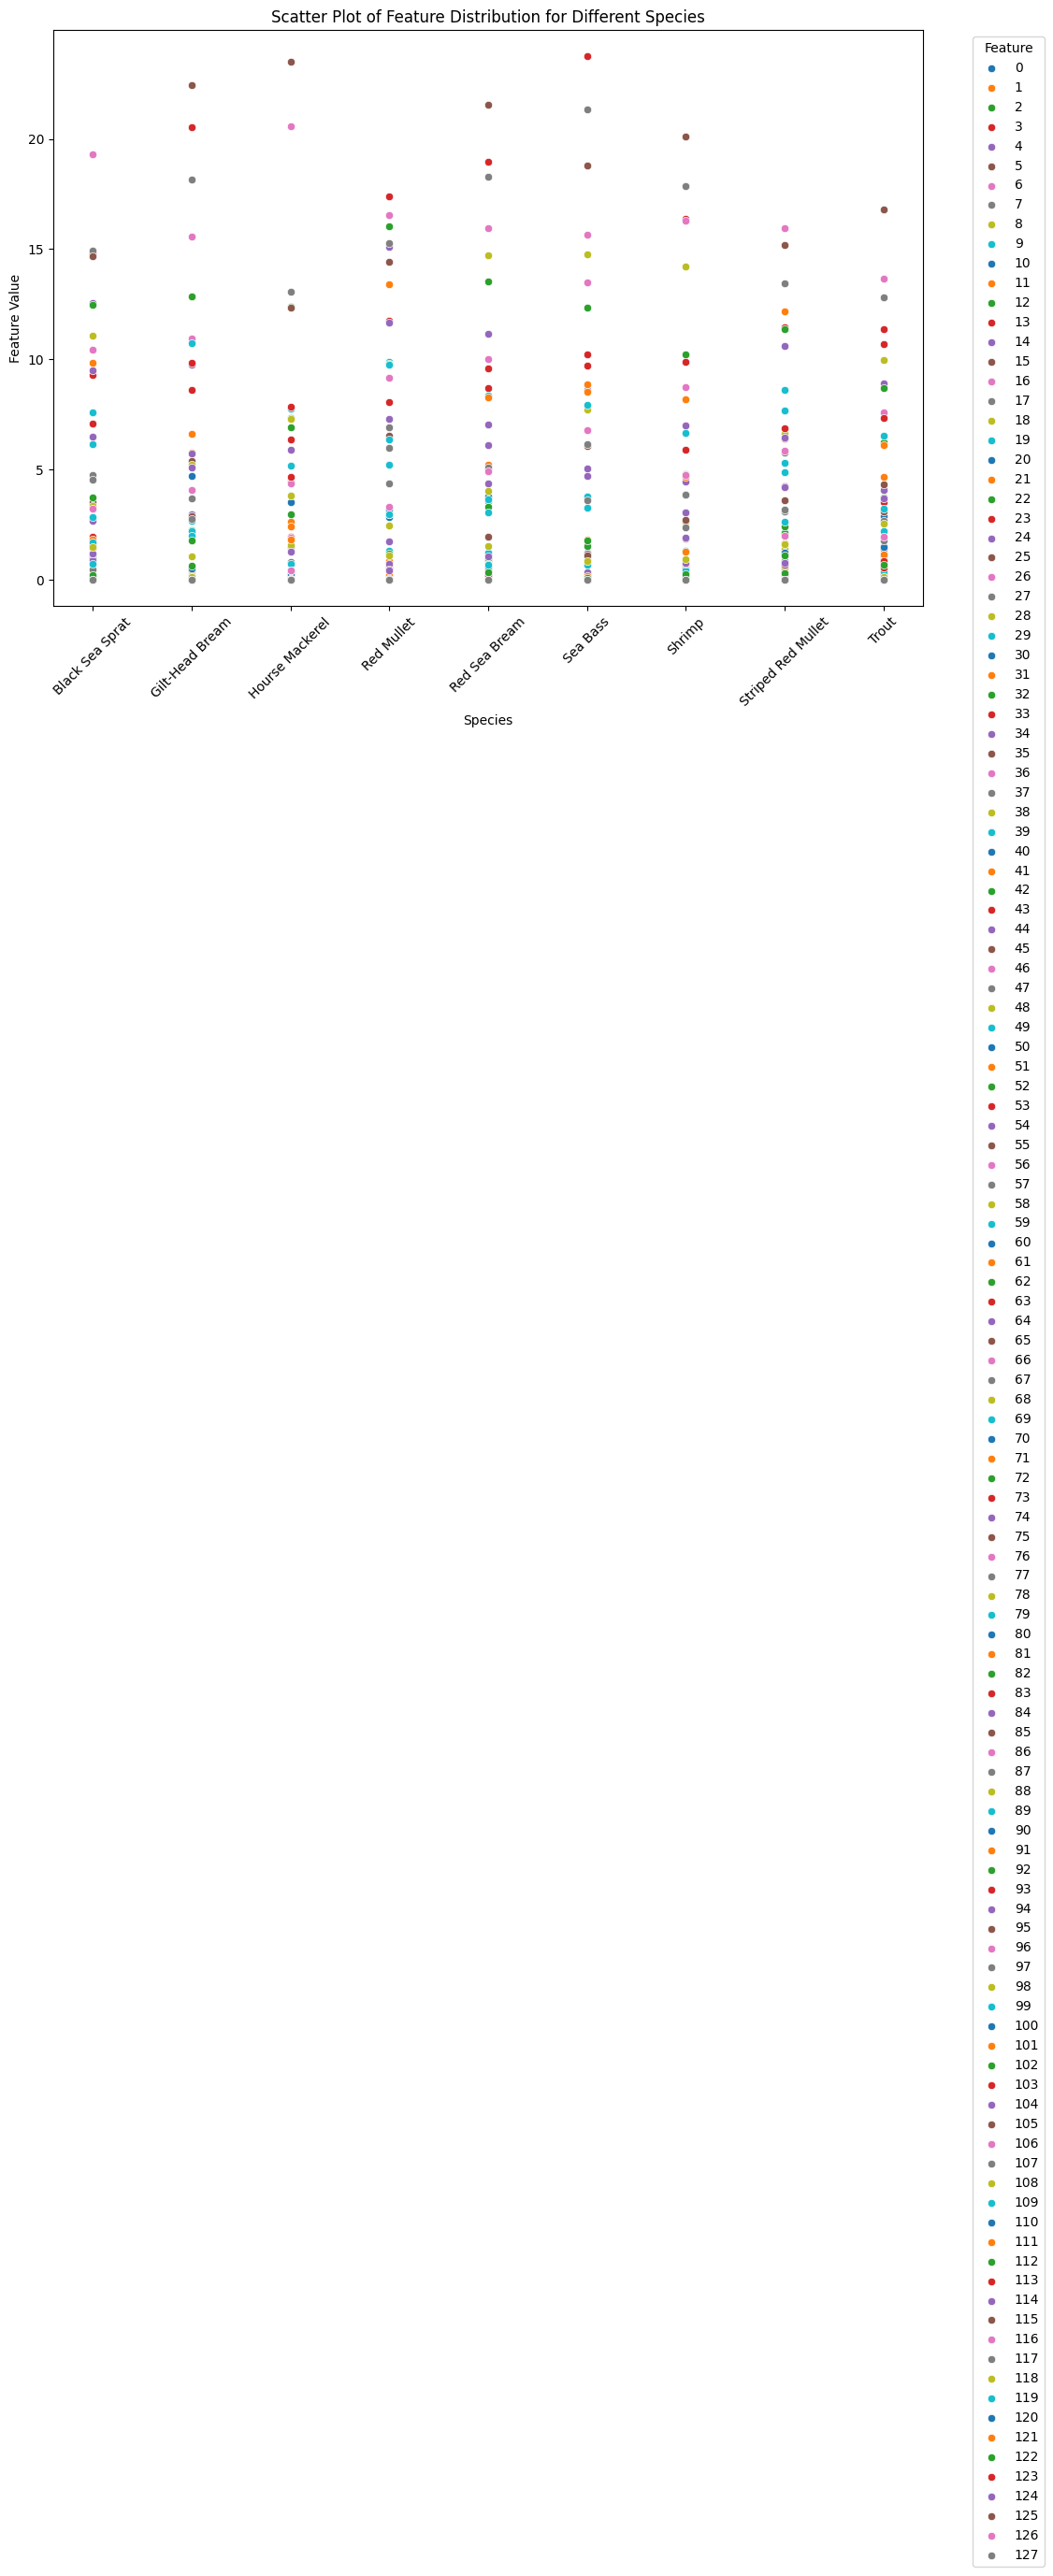

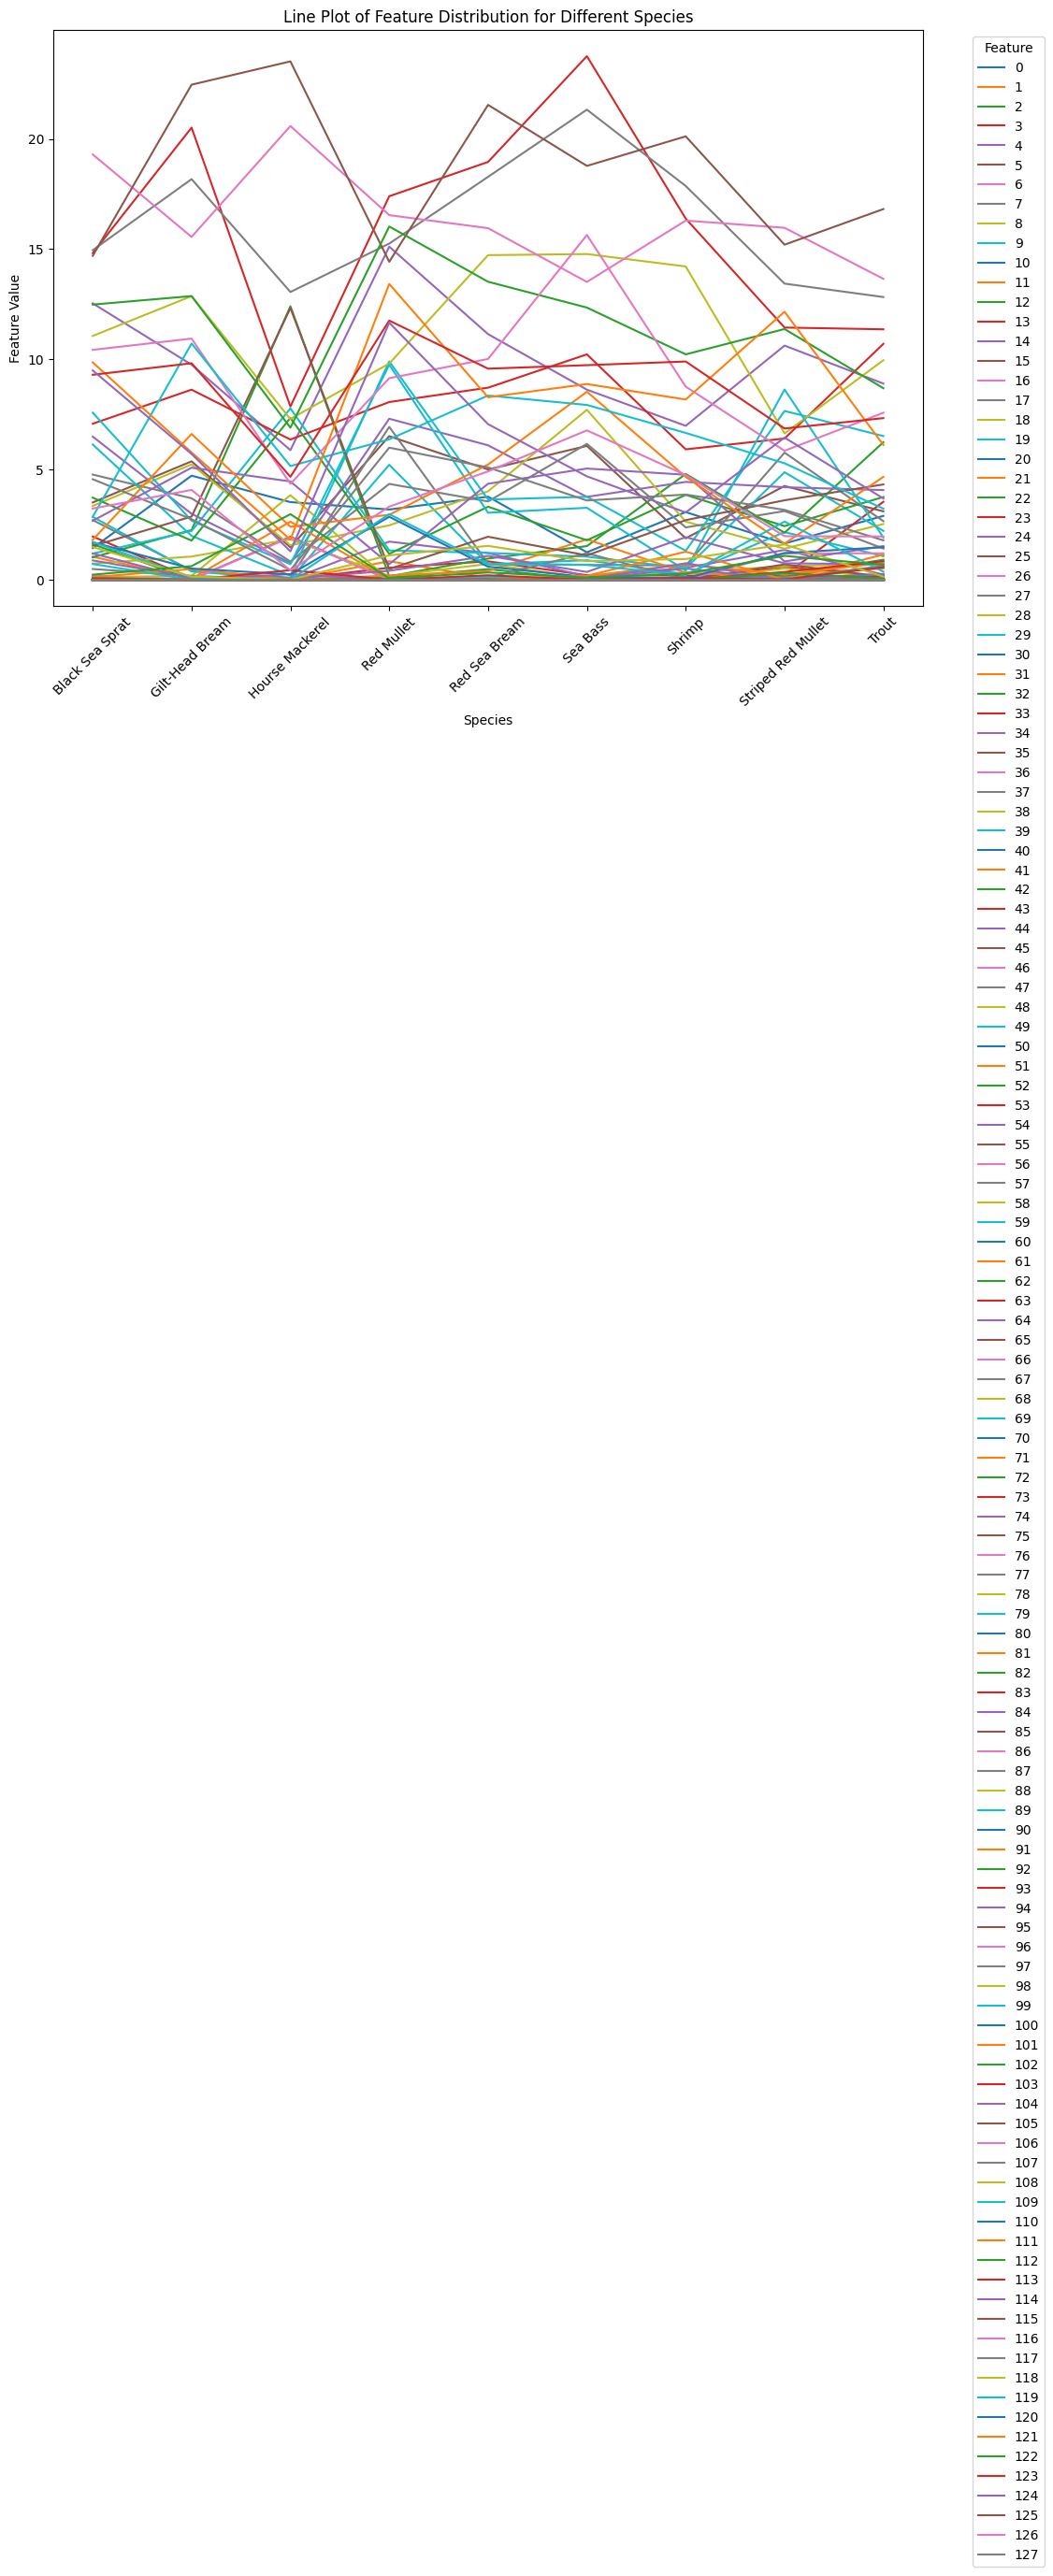

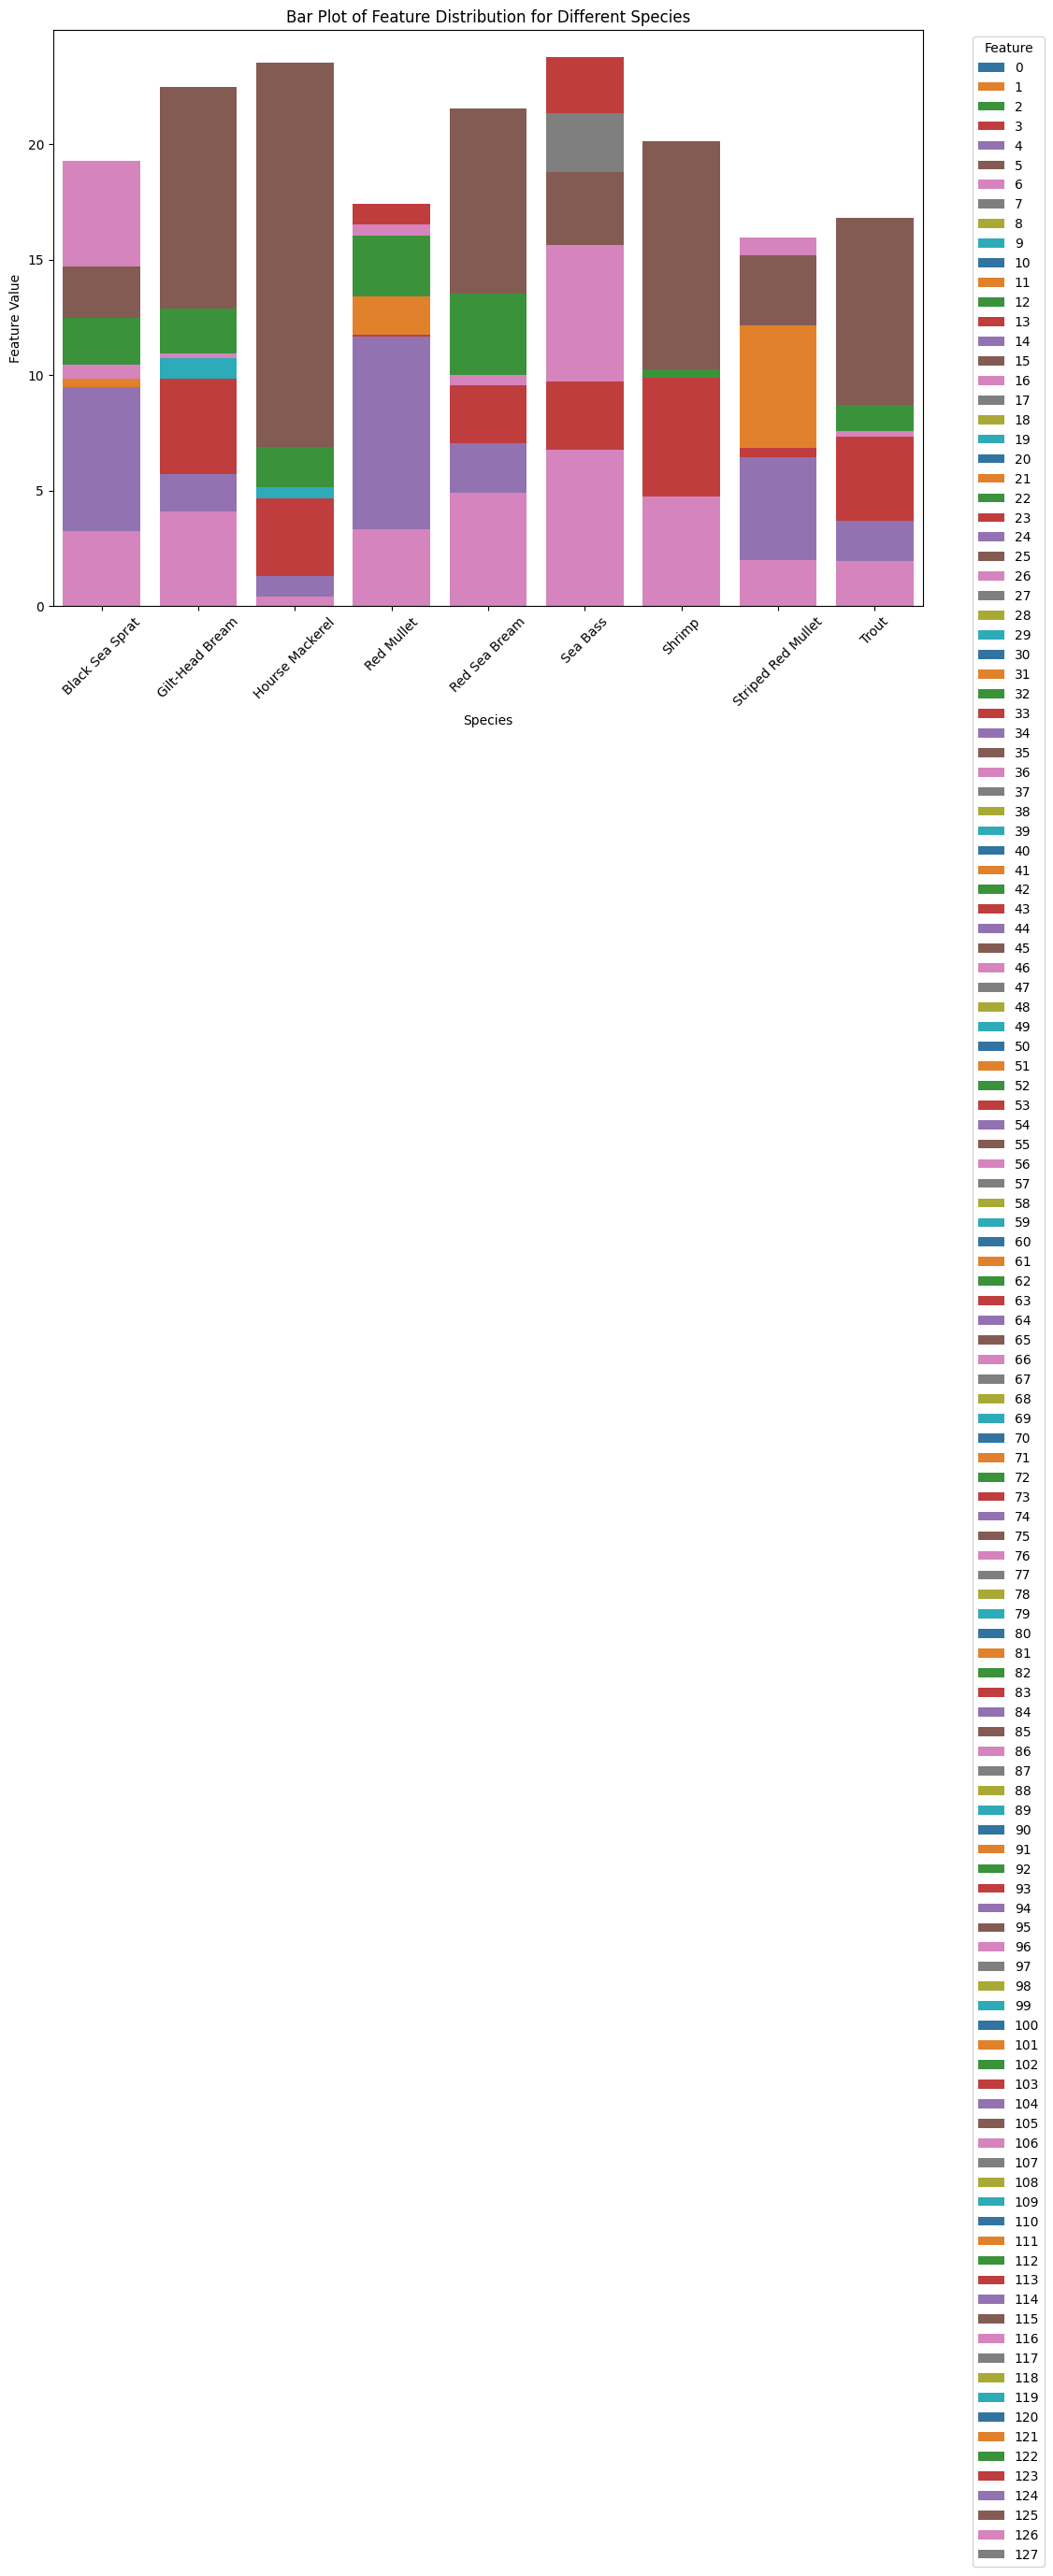

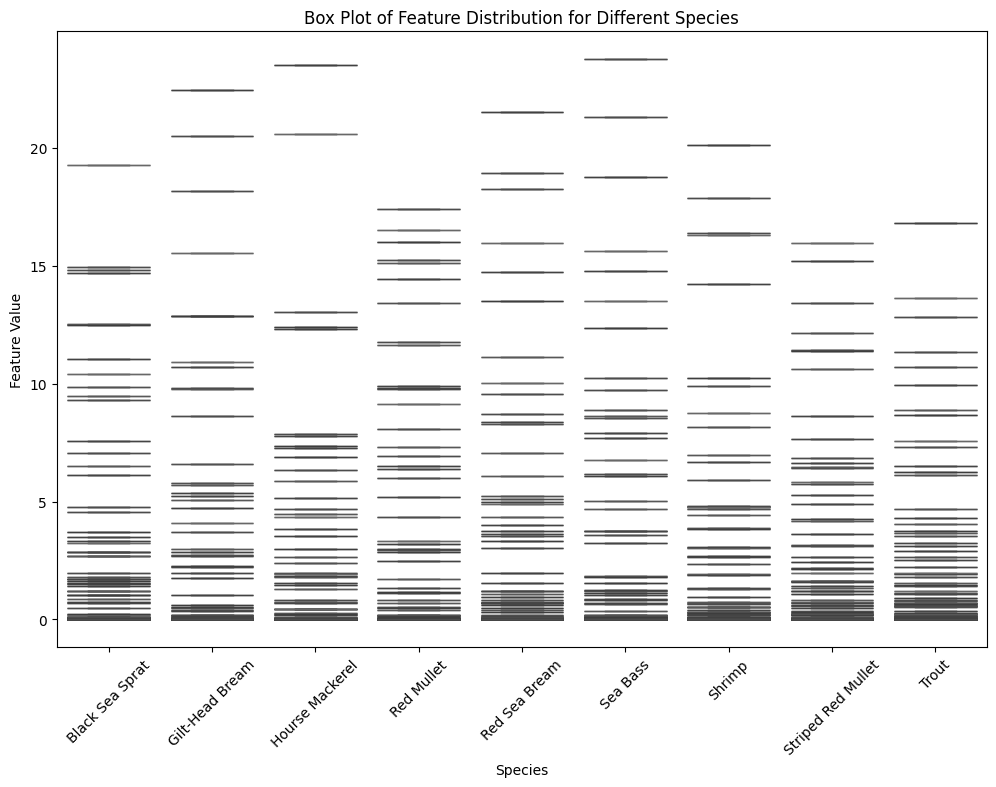

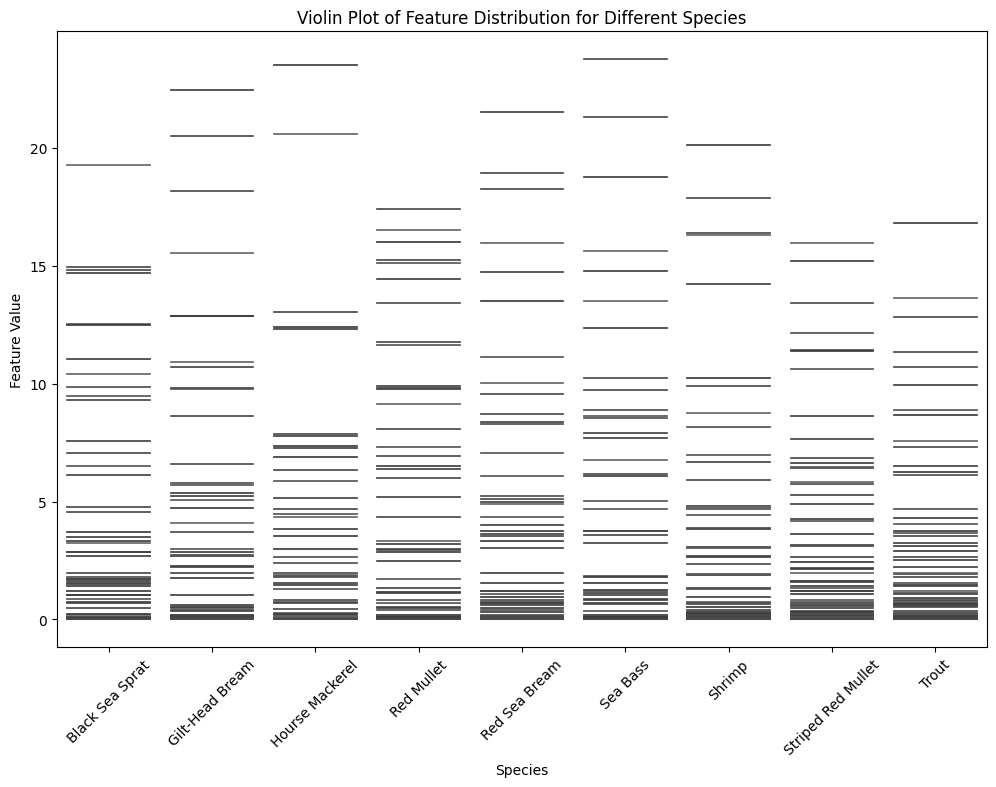

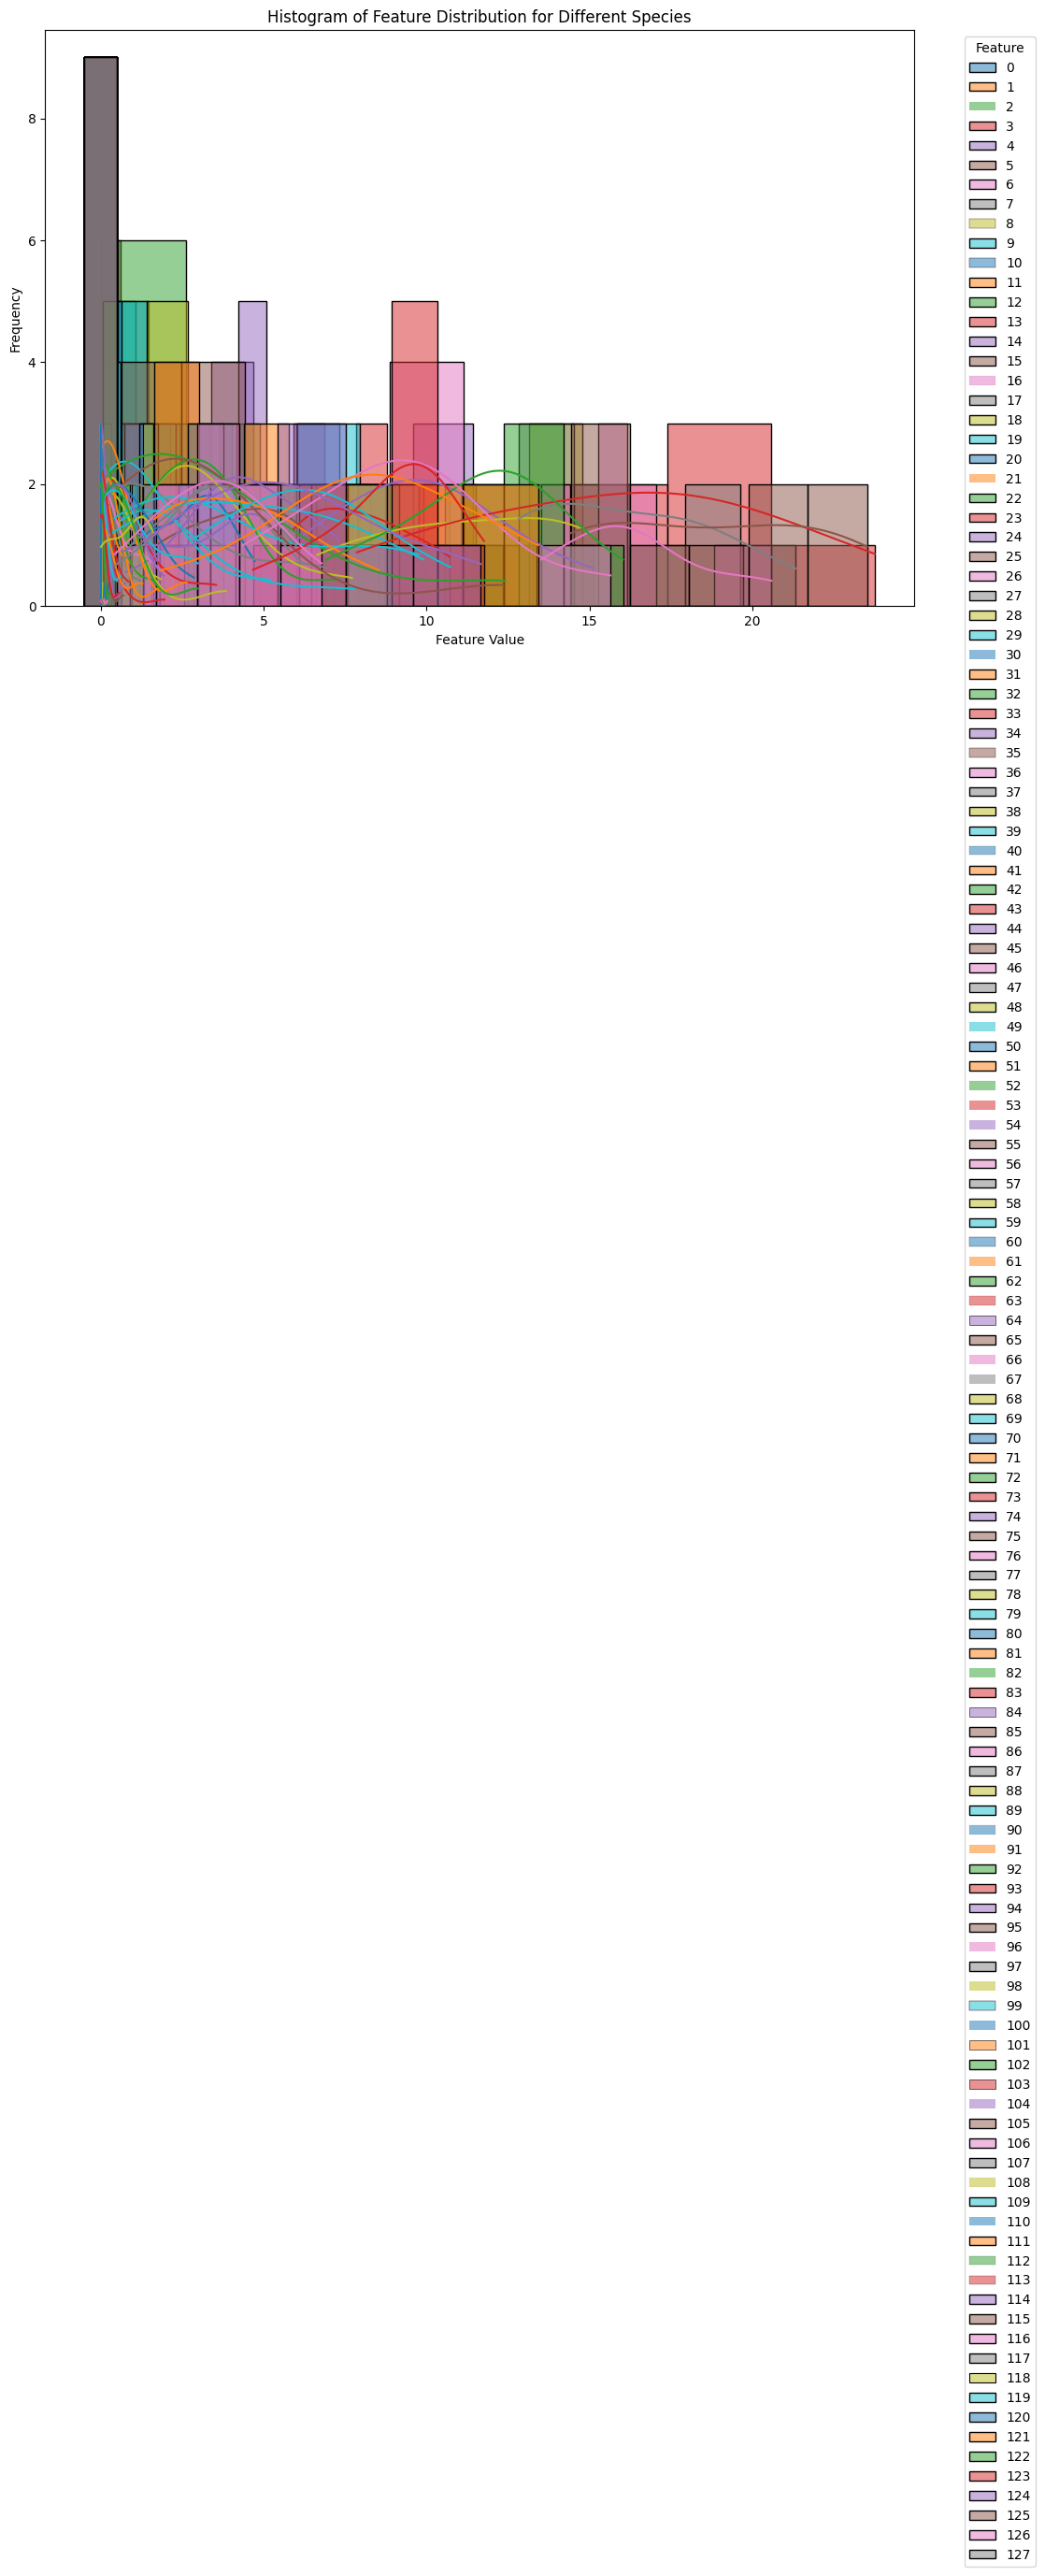

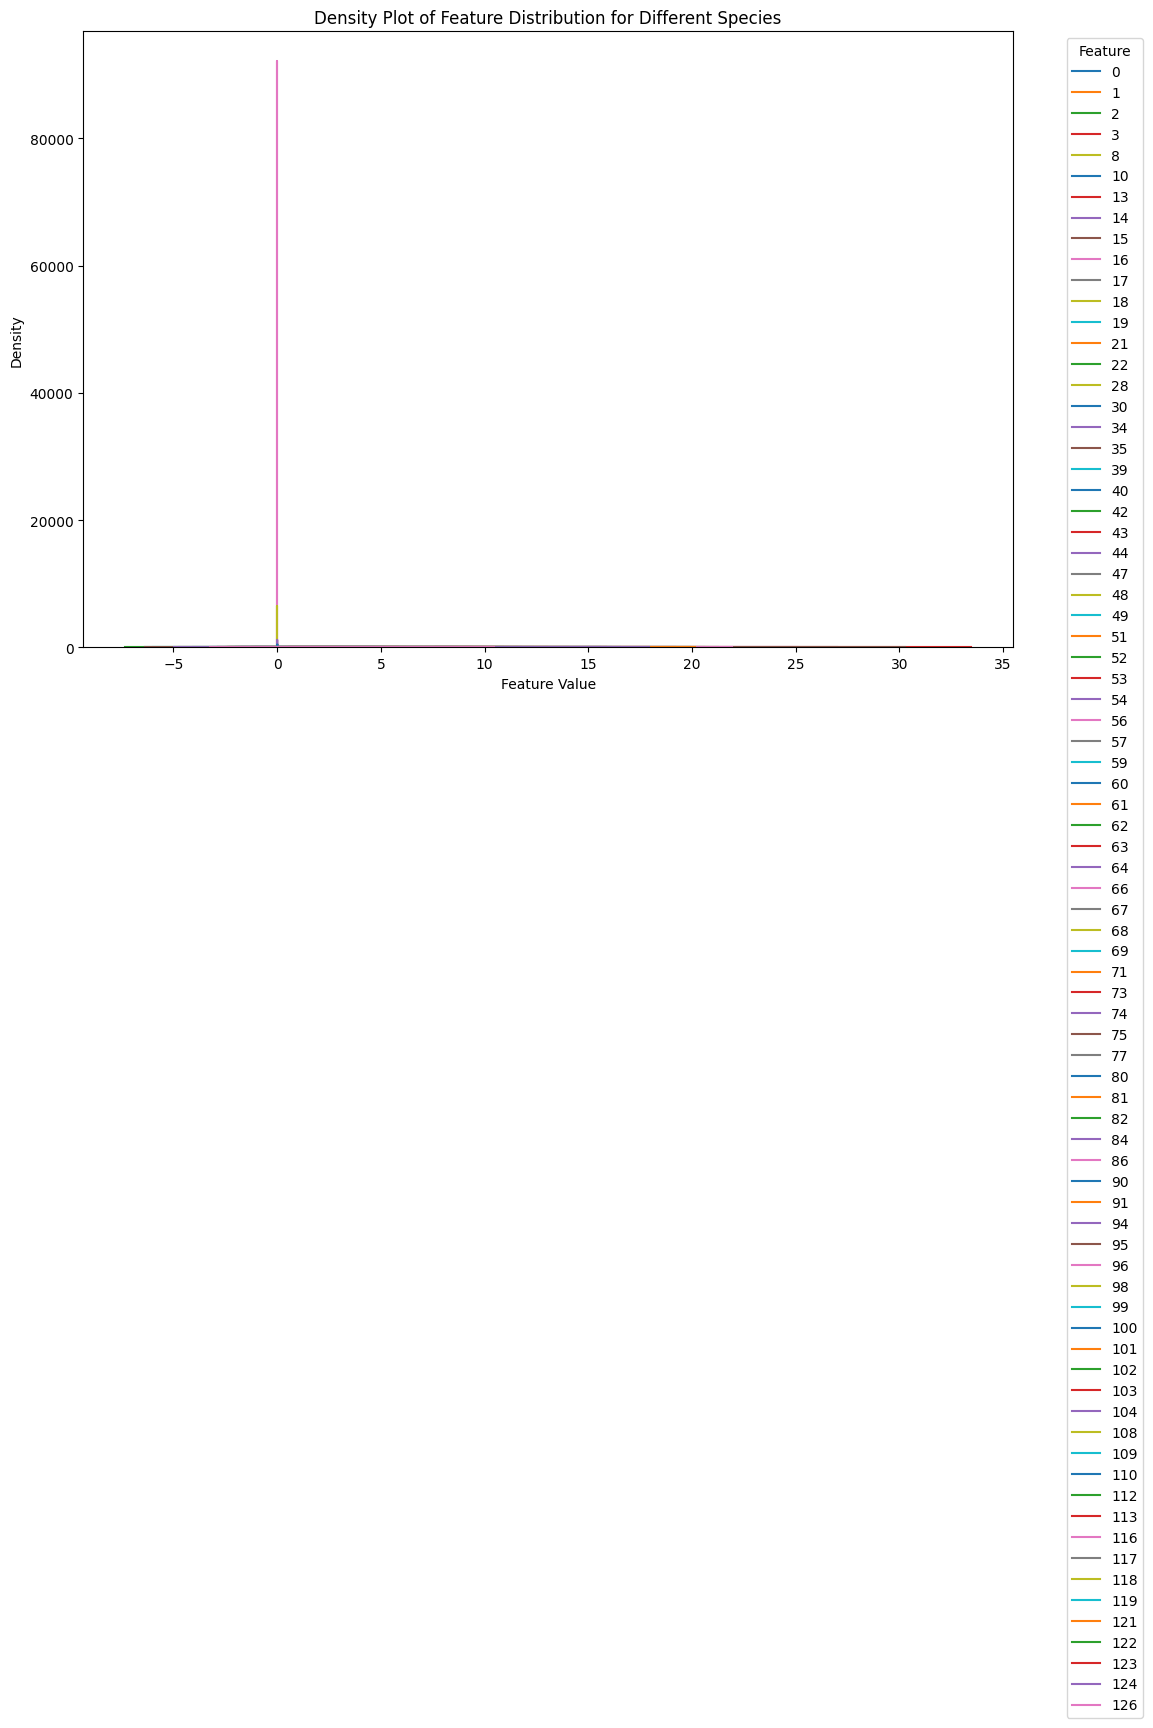

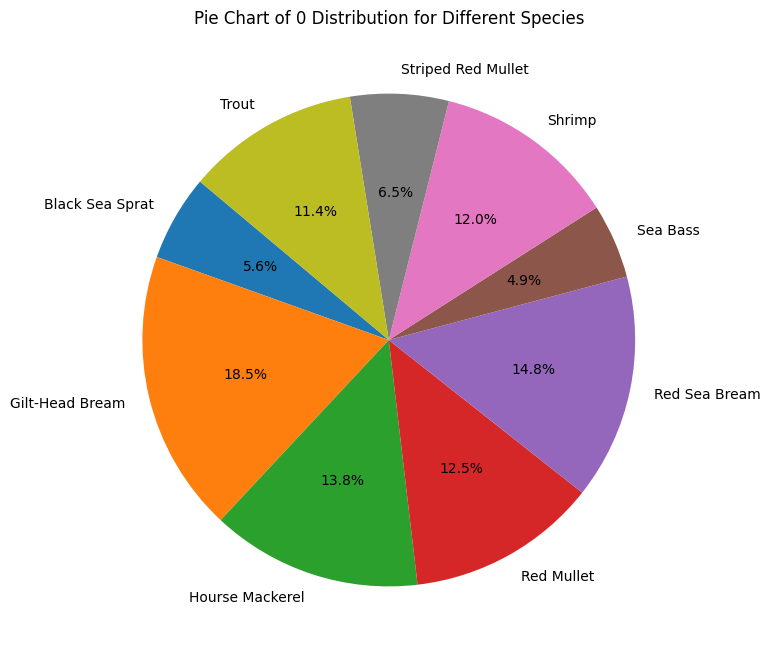

In [ ]:
#  Scatter Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.scatterplot(x='Species', y=feature, data=mean_species_features_df, label=feature)
plt.title('Scatter Plot of Feature Distribution for Different Species')
plt.xlabel('Species')
plt.ylabel('Feature Value')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

#  Line Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.lineplot(x='Species', y=feature, data=mean_species_features_df, label=feature)
plt.title('Line Plot of Feature Distribution for Different Species')
plt.xlabel('Species')
plt.ylabel('Feature Value')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

#  Bar Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.barplot(x='Species', y=feature, data=mean_species_features_df, label=feature)
plt.title('Bar Plot of Feature Distribution for Different Species')
plt.xlabel('Species')
plt.ylabel('Feature Value')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

# Box Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.boxplot(x='Species', y=feature, data=mean_species_features_df)
plt.title('Box Plot of Feature Distribution for Different Species')
plt.xlabel('Species')
plt.ylabel('Feature Value')
plt.xticks(rotation=45)
plt.show()

# Violin Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.violinplot(x='Species', y=feature, data=mean_species_features_df)
plt.title('Violin Plot of Feature Distribution for Different Species')
plt.xlabel('Species')
plt.ylabel('Feature Value')
plt.xticks(rotation=45)
plt.show()

#  Histogram
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.histplot(data=mean_species_features_df, x=feature, kde=True, label=feature)
plt.title('Histogram of Feature Distribution for Different Species')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#  Density Plot
plt.figure(figsize=(12, 8))
for feature in mean_species_features_df.columns[1:]:
    sns.kdeplot(data=mean_species_features_df, x=feature, label=feature)
plt.title('Density Plot of Feature Distribution for Different Species')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#  Pie Chart (for one feature)
feature = mean_species_features_df.columns[1]
plt.figure(figsize=(8, 8))
sizes = mean_species_features_df[feature]
labels = mean_species_features_df['Species']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of {feature} Distribution for Different Species')
plt.show()

In [ ]:
import tensorflow as tf

# Load the MobileNetV2 pretrained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Adjust input shape as per your requirements
    include_top=False,  # Exclude the top (classification) layer
    weights='imagenet',  # Use pretrained weights on ImageNet dataset
)

# Get the names of all layers in the model
layer_names = [layer.name for layer in pretrained_model.layers]

# Print the names of the layers
print(layer_names)


['input_3', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

1/1 [==============================] - 1s 964ms/step


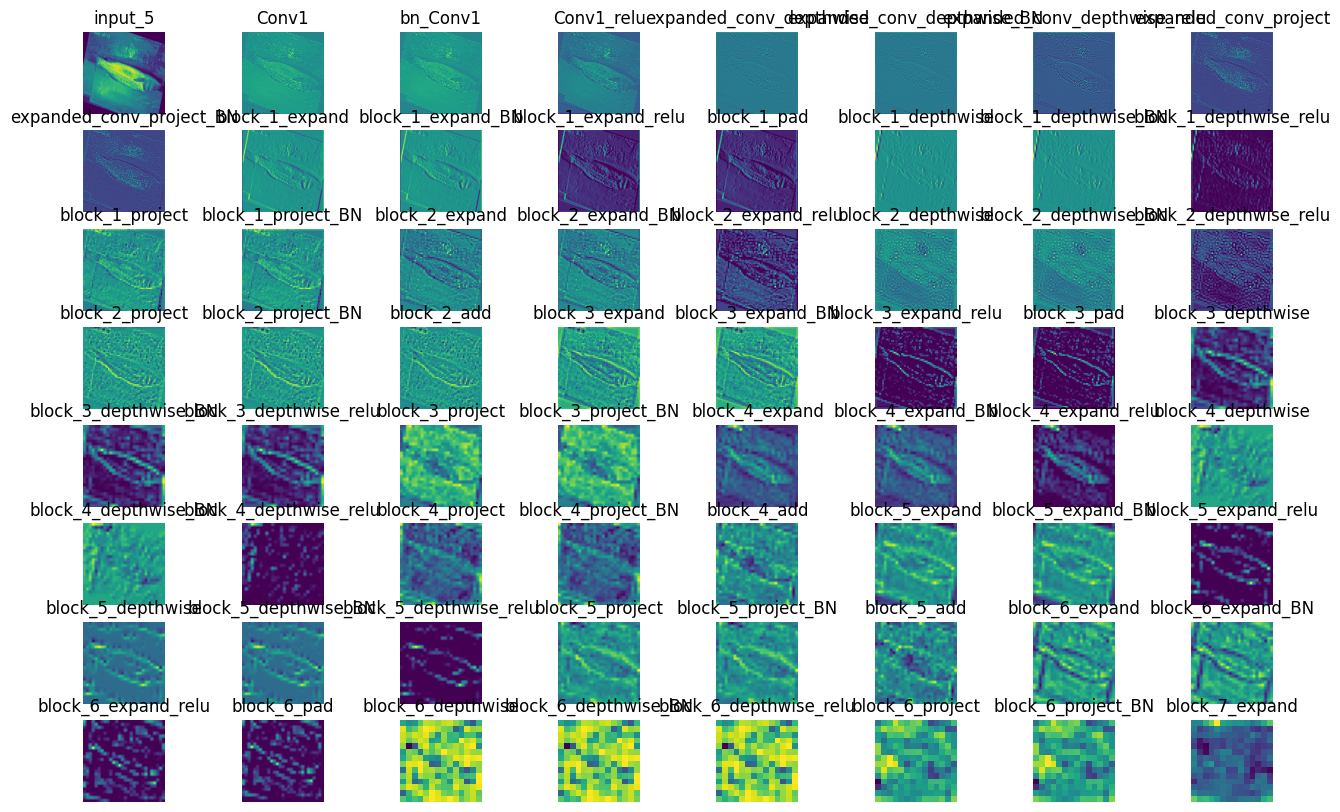

In [ ]:
model = MobileNetV2(weights='imagenet', include_top=True)

# Choose an image for visualization
img_path = '/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00005.png'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch dimension

# Preprocess the image
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
# Get activations of intermediate layers
layer_names = [layer.name for layer in model.layers]
outputs = [model.get_layer(name).output for name in layer_names]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=outputs)
activations = activation_model.predict(img_array)

# Limit the number of activations to fit within the subplot grid
num_activations = min(len(activations), 64)

# Visualize activations of specific layers
plt.figure(figsize=(16, 10))
for i in range(num_activations):
    plt.subplot(8, 8, i+1)
    plt.imshow(activations[i][0, :, :, 0], cmap='viridis')  # Visualize the first channel of each activation map
    plt.axis('off')
    plt.title(layer_names[i])
plt.show()

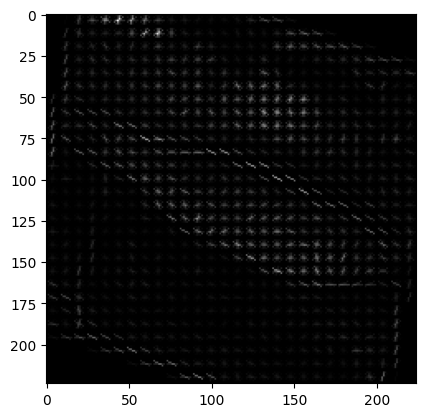

In [ ]:
from skimage.feature import hog
from skimage import exposure

# Example function to extract HOG features from an image
def extract_hog_features(image):
    # Compute HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), visualize=True, multichannel=True)
    # Rescale histogram for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features, hog_image_rescaled

# Example usage:
hog_features, hog_image = extract_hog_features(img_array[0])
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.show()